In [51]:
# Imports
import pandas as pd
import numpy as np
import datetime as dt
import math
import quandl
import pickle
import os
import matplotlib.pyplot as plt
from matplotlib import style
import warnings # current version of seaborn generates a bunch of warnings that will be ignore
warnings.filterwarnings('ignore')

# style.use("ggplot")
%matplotlib inline

from sklearn import preprocessing, cross_validation, svm
from sklearn.linear_model import LinearRegression

In [52]:
# Dividing the training and testing data in the ratio 70 : 30 
# dataframe = pd.read_csv("input.csv")
df = pd.read_csv(r"input.csv",
                  header=0, 
                  index_col='date_txn',
                  parse_dates=True)
from sklearn.model_selection import train_test_split
train, test = train_test_split(df, test_size=0.3)
train.head()

,symbol,open,low,high,close_price,volume,lead_1,lead_5,lead_10,name,class_type_of
date_txn,,,,,,,,,,,
2017-09-26,SPY,249.42,248.81,249.70,249.08,54062937,250.05,252.86,254.62,SPDR S&P500,S_P_500
2016-05-26,SPY,209.44,208.97,209.71,209.34,53087800,210.24,210.28,210.07,SPDR S&P500,S_P_500
2016-10-19,SPY,214.02,213.60,214.64,214.28,64360800,213.88,213.74,209.74,SPDR S&P500,S_P_500
2016-08-22,SPY,218.26,217.83,218.80,218.53,60068900,218.97,218.36,219.03,SPDR S&P500,S_P_500
2017-08-15,SPY,246.98,246.16,247.00,246.51,52419341,246.94,245.44,244.85,SPDR S&P500,S_P_500


In [53]:
# High-low percentage
df.rename(columns={'close_price': 'Adj. Close', 'high': 'Adj. High', 'open': 'Adj. Open', 'low': 'Adj. Low', 'volume': 'Adj. Volume'}, inplace=True)
df['HL_PCT'] = (df['Adj. High'] - df['Adj. Low']) / df['Adj. Low'] * 100

# Percentage change ((new - old) / old * 100)
df['PCT_change'] = (df['Adj. Close'] - df['Adj. Open']) / df['Adj. Open'] * 100

# Define useful columns
columns = [
    'Adj. Close',
    'Adj. Volume',
    'HL_PCT',
    'PCT_change',
]

df = df[columns]

df.head()

,Adj. Close,Adj. Volume,HL_PCT,PCT_change
date_txn,,,,
2015-11-10,208.55,71844000,0.680535,0.501181
2015-11-11,207.67,67251000,0.616392,-0.579280
2015-11-12,204.84,118209400,1.093643,-0.803874
2015-11-13,202.54,145494400,1.101561,-0.885735
2015-11-16,205.62,112996000,1.736077,1.631079


In [54]:
forecast_col = 'Adj. Close'

# fill column to prevent missing data
df.fillna(-99999, inplace=True)

# amount of days in advance
forecast_out = int(math.ceil(0.01*len(df)))
forecast_out

7

In [55]:
# set the label to the shift of the forecast col
df['label'] = df[forecast_col].shift(-forecast_out)
df.dropna(inplace=True)
df.head()

,Adj. Close,Adj. Volume,HL_PCT,PCT_change,label
date_txn,,,,,
2015-11-10,208.55,71844000,0.680535,0.501181,208.55
2015-11-11,207.67,67251000,0.616392,-0.579280,209.31
2015-11-12,204.84,118209400,1.093643,-0.803874,209.07
2015-11-13,202.54,145494400,1.101561,-0.885735,209.35
2015-11-16,205.62,112996000,1.736077,1.631079,209.32


In [56]:
# X feature
# build up a dataset of everything expect the column label
X = np.array(df.drop(['label'], 1))

X = preprocessing.scale(X)
X_lately = X[-forecast_out:]
# X = X[:-forecast_out]

df.dropna(inplace=True)

# y labels
# build dataset of only the column label
y = np.array(df['label'])

# Create the train and test set
X_train, X_test, y_train, y_test = cross_validation.train_test_split(X, y, test_size=0.2)

In [62]:
if os.path.exists('model.pickle'):
    pickle_in = open('model.pickle','rb')
    clf = pickle.load(pickle_in)
else:
    clf = LinearRegression()
    # Train the model
    clf.fit(X_train, y_train)

    with open('model.pickle','wb') as f:
        pickle.dump(clf, f)

# Test the accuracy
clf.score(X_test, y_test)

0.9687221666777431

In [63]:
forecast_set = clf.predict(X_lately)
forecast_set

array([273.5492798 , 271.52573367, 272.80118985, 272.70057297,
       271.68795377, 274.21031179, 273.27874873])

In [64]:
df['Forecast'] = np.nan
last_date = df.iloc[-1].name
last_unix = last_date.timestamp()
one_day = 86400
next_unix = last_unix + one_day

for i in forecast_set:
    next_date = dt.datetime.fromtimestamp(next_unix)
    next_unix += one_day
    df.loc[next_date] = [np.nan for _ in range(len(df.columns)-1)]+[i]
df.head()

,Adj. Close,Adj. Volume,HL_PCT,PCT_change,label,Forecast
date_txn,,,,,,
2015-11-10,208.55,71844000.0,0.680535,0.501181,208.55,NaN
2015-11-11,207.67,67251000.0,0.616392,-0.579280,209.31,NaN
2015-11-12,204.84,118209400.0,1.093643,-0.803874,209.07,NaN
2015-11-13,202.54,145494400.0,1.101561,-0.885735,209.35,NaN
2015-11-16,205.62,112996000.0,1.736077,1.631079,209.32,NaN


In [65]:
df.tail()

,Adj. Close,Adj. Volume,HL_PCT,PCT_change,label,Forecast
date_txn,,,,,,
2018-06-01 11:00:00,NaN,NaN,NaN,NaN,NaN,272.801190
2018-06-02 11:00:00,NaN,NaN,NaN,NaN,NaN,272.700573
2018-06-03 11:00:00,NaN,NaN,NaN,NaN,NaN,271.687954
2018-06-04 11:00:00,NaN,NaN,NaN,NaN,NaN,274.210312
2018-06-05 11:00:00,NaN,NaN,NaN,NaN,NaN,273.278749


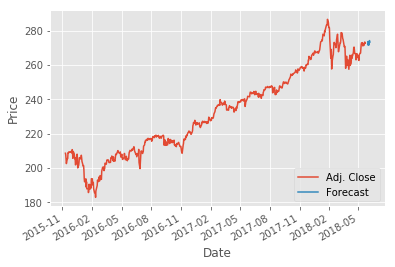

In [66]:
import pylab
df['Adj. Close'].plot()
df['Forecast'].plot()
plt.legend(loc=4)
plt.xlabel('Date')
plt.ylabel('Price')
plt.show()
# plt.savefig('foo.png')
plt.savefig('foo.pdf', bbox_inches='tight')